<a href="https://colab.research.google.com/github/Leonild/TimeSeriesDataAnalysis/blob/main/%5BPhD%5DTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data and Unzip
https://aqs.epa.gov/aqsweb/airdata/download_files.html

In [1]:
# Ozone
!wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2022.zip
!wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2021.zip
!wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2020.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2019.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2018.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2017.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2016.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2015.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2014.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2013.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2012.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2011.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2010.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2009.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2008.zip
# !wget https://aqs.epa.gov/aqsweb/airdata/daily_44201_2007.zip

--2023-11-22 22:00:53--  https://aqs.epa.gov/aqsweb/airdata/daily_44201_2022.zip
Resolving aqs.epa.gov (aqs.epa.gov)... 134.67.21.26, 2620:117:506f:15::f01a
Connecting to aqs.epa.gov (aqs.epa.gov)|134.67.21.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2710610 (2.6M) [application/zip]
Saving to: ‘daily_44201_2022.zip’

daily_44201_2022.zi 100%[===================>]   2.58M  2.41MB/s    in 1.1s    

2023-11-22 22:00:55 (2.41 MB/s) - ‘daily_44201_2022.zip’ saved [2710610/2710610]

--2023-11-22 22:00:55--  https://aqs.epa.gov/aqsweb/airdata/daily_44201_2021.zip
Resolving aqs.epa.gov (aqs.epa.gov)... 134.67.21.26, 2620:117:506f:15::f01a
Connecting to aqs.epa.gov (aqs.epa.gov)|134.67.21.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4458666 (4.3M) [application/zip]
Saving to: ‘daily_44201_2021.zip’

daily_44201_2021.zi 100%[===================>]   4.25M  2.65MB/s    in 1.6s    

2023-11-22 22:00:56 (2.65 MB/s) - ‘daily_44201_2021.

In [2]:
!unzip daily_44201_2022.zip -d data
!unzip daily_44201_2021.zip -d data
!unzip daily_44201_2020.zip -d data
# !unzip daily_44201_2019.zip -d data
# !unzip daily_44201_2018.zip -d data
# !unzip daily_44201_2017.zip -d data
# !unzip daily_44201_2016.zip -d data
# !unzip daily_44201_2015.zip -d data
# !unzip daily_44201_2014.zip -d data
# !unzip daily_44201_2013.zip -d data
# !unzip daily_44201_2012.zip -d data
# !unzip daily_44201_2011.zip -d data
# !unzip daily_44201_2010.zip -d data
# !unzip daily_44201_2009.zip -d data
# !unzip daily_44201_2008.zip -d data
# !unzip daily_44201_2007.zip -d data

Archive:  daily_44201_2022.zip
  inflating: data/daily_44201_2022.csv  
Archive:  daily_44201_2021.zip
  inflating: data/daily_44201_2021.csv  
Archive:  daily_44201_2020.zip
  inflating: data/daily_44201_2020.csv  


# Spatial Aggrefation

In [3]:
!pip install geopandas
!pip install pyproj
#!pip install shapefile
!pip install fiona

In [4]:
from geopy.geocoders import Nominatim
import geopy.distance
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sin, cos, sqrt, atan2, radians

#trabalhando com as coordenadas
import geopandas as gpd
from pyproj import Proj, transform

#import shapefile
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import sys


class Agregation:

	def __init__(self, dataset):
		self.dataset = self.initialize(dataset)
		print(self.dataset.head())
		#exit()

	# initialize the dataset by removing the undesire columns, assigning date to index, and grouping by month (commented)
	def initialize(self, dataset):
		#removing undesired columns
		dataset = dataset[['Date Local','Latitude','Longitude','AQI']]
		dataset = dataset.dropna()
		dataset = dataset.rename(columns={"Date Local": "Date", "AQI": "AQI", "Latitude": "latitude", "Longitude": "longitude"})
		# Convert the date to datetime64
		dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y-%m-%d')
		#dataset.index = dataset['Date'] # to work the next line
		#grouping by month
		#dataset = dataset.groupby(pd.Grouper(freq='M')).mean() #grouping data by month
		dataset.insert(loc=0, column='w', value=np.nan)
		return dataset

	#fill w field, identify what data belongs to the specific polygon
	def geopointWithinShape(self, grid):
		shapes = grid
		soa_shape_map_geo = shapes.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
		print("Iniciando verificacao")
		cities = self.dataset
		# reading each shape polygon
		i = 1 # polygon index
		aux = pd.DataFrame()
		isNotInto = True
		for multi in shapes['geometry']:
			# checar se eh POLYGON ou MULTIPOLYGON
			if multi.geom_type == 'MultiPolygon':
				try:
					for poly in multi:
						isNotInto = True
						poly = shape(poly)
						for index, row in cities.iterrows():
							pt = Point((row['longitude'], row['latitude']))
							#print("Lendo poligono: ", poly)
							if pt.within(poly):
								cities.at[index, 'w'] = i #atribuindo o id do arranjo
								isNotInto = False
								#row['w'] = i
								#aux = aux.append(cities.ix[index]) # ix is deprecated
								#aux = aux.append(cities.iloc[index]) #The frame.append method is deprecat
								#aux = pd.concat([aux,cities.iloc[index]])#,axis=1)
								print(pt, " está no poligono ", i)
						# if not data into plygon appending a row
						if(isNotInto):
							# Appending a row to csv with missing entries
							#row_contents = pd.DataFrame({'w': [i], 'Address': ['0'], 'DateLocalCount': 0.0, 'longitude': 0.0, 'latitude': 0.0,
							#'NO2AQI': 0.0, 'O3AQI': 0.0, 'SO2AQI': 0.0, 'COAQI': 0.0})
							row_contents = pd.DataFrame({'w': [i], 'Date': np.nan,'AQI': np.nan, 'latitude': np.nan, 'longitude': np.nan})
							#cities = cities.append(row_contents, ignore_index=True) #The frame.append method is deprecat
							cities = pd.concat([cities,row_contents])#, axis=1)
							#aux = aux.append(row_contents) #The frame.append method is deprecat
							#aux = pd.concat([aux,row_contents], ignore_index=True, sort=False)
							print("Adicionou a linha ", i)
						i+=1
				except:
					print("MultiPolygon ",i ,"object is not iterable")
					i+=1
			elif multi.geom_type == 'Polygon':
				poly = shape(multi)
				for index, row in cities.iterrows():
					pt = Point((row['longitude'], row['latitude']))
					#print("Lendo poligono: ", poly)
					if pt.within(poly):
						cities.at[index, 'w'] = i #atribuindo o id do arranjo
						#row['w'] = i
						isNotInto = False
						#aux = aux.append(cities.ix[index]) # ix is deprecated
						#aux = aux.append(cities.iloc[index]) #The frame.append method is deprecat
						#aux = pd.concat([aux,cities.iloc[index]])#, axis=1)
						print(pt, " está no poligono ", i)
				# if not data into plygon appending a row
				if(isNotInto):
					# Appending a row to csv with missing entries
					##row_contents = pd.DataFrame({'w': [i], 'Address': ['0'], 'DateLocalCount': 0.0, 'longitude': 0.0, 'latitude': 0.0,
					#	'NO2AQI': 0.0, 'O3AQI': 0.0, 'SO2AQI': 0.0, 'COAQI': 0.0})
					row_contents = pd.DataFrame({'w': [i], 'latitude': np.nan, 'longitude': np.nan,'AQI': np.nan})
					#cities = cities.append(row_contents, ignore_index=True) #The frame.append method is deprecat
					cities = pd.concat([cities,row_contents], ignore_index=True, sort=False)
					#append_list_as_row('./pre-final-file.csv', row_contents)
					#aux = aux.append(row_contents) #The frame.append method is deprecat
					#aux = pd.concat([aux,row_contents])#, axis=1)

			else:
				print("Nao identificado")
			i+=1
			isNotInto = True

		# aux.to_csv('./new-final-file.csv', index=False)
		#print(aux)
		self.dataset = cities.reset_index()#aux.reset_index()
		return cities#aux

	#grouping and save data by data location inside a polygon. This method will return the final file for the Autocorrelatin
	def groupByPolygon(self):
		grouped = self.dataset#[['w','AQI']]
		grouped = grouped[grouped.w.notnull()]  # Delete rows with NAs
		#grouped = grouped.groupby(['w']).mean()#count()[['DateLocal']]  # testendo a funcao contar
		grouped = grouped.sort_values(by=['w'])
		self.dataset = grouped.reset_index()

	#salve the dataframe into a csv
	def saveData(self, file_name):
		self.dataset.to_csv(file_name, index=False)

In [9]:
!unzip /content/100km.zip -d /content/grid/100km/

Archive:  /content/100km.zip
 extracting: /content/grid/100km/hex-grid.dbf  
 extracting: /content/grid/100km/hex-grid.prj  
 extracting: /content/grid/100km/hex-grid.shp  
 extracting: /content/grid/100km/hex-grid.shx  


In [10]:
if __name__ == "__main__":

  for year in range(2022,2023,1):
    # year = sys.argv[2]
    # originalPath = sys.argv[1]
    originalPath = '/content/data'
    path = originalPath + "/daily_44201_" + str(year) + ".csv"
    #print('Starting spatioal agregation for ', path)
    dataSet = pd.read_csv(path) #O3
    a = Agregation(dataSet)

    print('identificando dados nos poligonos')
    originalPath = "grid/100km"
    pathPoligon = originalPath + "/hex-grid.shp"
    grid = gpd.read_file(pathPoligon)
    a.geopointWithinShape(grid)
    print('Agrupando por poligono e salvando')
    a.groupByPolygon()
    print('salvando arquivo')
    pathTo = "/content/grid/" + str(year) + "-final-file.csv"
    a.saveData(pathTo)

Streaming output truncated to the last 5000 lines.
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67
POINT (-117.33098 33.67649)  está no poligono  67

# Time Series

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# functions for the autocorrelation calc and partial autocorrelation calc
import statsmodels.api as sm
# ignore not crucial warnings
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sys


class Agregation:

	def __init__(self, path, dataset, polygon):
		#self.dataset = self.initialize(dataset)
		#self.dataset = pd.DataFrame(columns = ["Date", "AQI", "latitude","longitude"])
		if not dataset.empty:
			self.dataset = dataset.drop(['level_0','index'], axis=1)
			self.dataset['Date'] = pd.to_datetime(self.dataset['Date'], format='%Y/%m/%d')
			self.dataset.index = self.dataset['Date'] # to work plot the timeline
		else:
			self.dataset = dataset
		self.path = path
		self.polygon = polygon
		self.polygonData = {}

	# autoregressive integrated moving average (ARIMA)
	def arima(self):
		p,d,q = 1,0,0
		ts = 'AQI'
		df = self.dataset
		model = ARIMA(df[ts], order=(p,d,q))
		results_arima = model.fit()

		len_results = len(results_arima.fittedvalues)
		ts_modify = df[ts][-len_results:]
		# root sum of squares
		rss = sum((results_arima.fittedvalues - ts_modify)**2)
		# root mean sum error
		rmse = np.sqrt(rss/len(df[ts]))

		print('RMSE: ', rmse)

		plt.figure()
		plt.plot(df[ts], label='Original data')
		plt.plot(results_arima.fittedvalues, color='red', label='Prediction')
		plt.legend()
		#plt.show()
		savePath = self.path + "/" + str(self.polygon) + "-arima.png"
		plt.savefig(savePath)
		plt.clf()

	# add others datasets
	def appendDataset(self, dataset):
		#newDataset = self.initialize(dataset)
		self.dataset = self.dataset.append(dataset)
		self.dataset = self.dataset.sort_index()

	# initialize the dataset by removing the undesire columns, assigning date to index, and grouping by month (commented)
	def initialize(self, dataset):
		#removing undesired columns
		dataset = dataset.drop(['Source','Site ID','UNITS','POC','STATE','STATE_CODE','COUNTY_CODE','COUNTY','Daily Max 8-hour Ozone Concentration','Site Name','DAILY_OBS_COUNT','PERCENT_COMPLETE','AQS_PARAMETER_CODE','AQS_PARAMETER_DESC','CBSA_CODE','CBSA_NAME'],axis=1)
		dataset = dataset.dropna()
		# Convert the date to datetime64
		dataset['Date'] = pd.to_datetime(dataset['Date'], format='%m/%d/%Y')
		dataset.index = dataset['Date'] # to work the next line
		#grouping by month
		dataset = dataset.groupby(pd.Grouper(freq='M')).mean() #grouping data by month
		dataset = dataset.rename(columns={"Date": "Date", "DAILY_AQI_VALUE": "AQI", "SITE_LATITUDE": "latitude", "SITE_LONGITUDE": "longitude"})
		return dataset

	#correlogram: autocorrelation representation
	def correlogram(self):
		#returns ndarray with a partial autocorrelations for lags 0, 1, …, nlags. Shape (nlags+1,) | ols : regression of time series on lags of it and on constant
		correlation = sm.tsa.stattools.pacf_ols(self.dataset['AQI'])
		#lag_plot(correlation)#.imshow()
		title = 'Autocorrelation: AQI'
		lags = 10
		#plot_acf(correlation,title=title,lags=lags)
		sm.graphics.tsa.plot_pacf(correlation,title=title,lags=lags)
		#plt.show()
		savePath = self.path + "/" + str(self.polygon) + "-correlogram.png"
		plt.savefig(savePath)
		plt.clf()

	# plot data in a simple time series description
	def plotTimeSeries(self):
		self.dataset = self.dataset.sort_index()
		plt.rc('font', size=10)
		#moving average by month
		self.dataset['Moving-Average'] = self.dataset['AQI'].rolling(window=12).median()
		#self.dataset[['DAILY_AQI_VALUE','Moving-Average']].plot(figsize=(12,9))

		plt.plot(self.dataset.index,self.dataset['AQI'],label="Ozone",color="red") # Plota os dados
		plt.plot(self.dataset.index,self.dataset['Moving-Average'],label="Moving Average",color="blue") # Plota os dados
		plt.title('Ozone Polution')
		plt.xlabel("Date")
		plt.ylabel("O3")
		plt.ylim()
		#plt.show()
		#plt.savefig("./"+graphName)
		#plt.clf()
		savePath = self.path + "/" + str(self.polygon) + "-TimeSeries.png"
		plt.savefig(savePath)
		plt.clf()

	#Arima with seasonality
	def sarima(self):
		np.random.seed(0)

		# fiting the SARIMA model
		#auto_arima(self.dataset['AQI'],seasonal=True,m=7).summary()


		#stepwise_fit = auto_arima(self.dataset['AQI'], start_p=0, start_q=0,
		#						max_p=6, max_q=3, m=7,
		#						seasonal=True,
		#						trace=True,
		#						error_action='ignore',
		#						suppress_warnings=True,
		#						stepwise=True)

		#stepwise_fit.summary() #Best model was:  ARIMA(6,0,1)(0,0,1)[7] intercept
		# seen prediction
		division = len(self.dataset)
		trainning = self.dataset[:int(division*0.8)]
		test = self.dataset[int(division*0.8):]

		model = SARIMAX(trainning['AQI'],order=(6,0,1),seasonal_order=(0,0,1,7))
		result = model.fit()
		result.summary()
		result.fittedvalues

		# Obtain predicted values
		start=len(trainning)
		end=len(trainning)+len(test)-1
		#dynamic = False means that ever point is generate by using the whole historic util the point
		#typ = 'levels' to predict the original variables. If it was typ = 'linear' woud be a linear prediction in diferencial variable.
		prediction = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('Prediction SARIMA(6,0,1)(0,0,1,7) ')
		prediction.index = test.index

	#salve the dataframe into a csv
	def saveData(self, file_name):
		self.dataset.to_csv(file_name, index=False)

	# Plot a seasonal decompose
	def seasonalDecompose(self):
		f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,5), sharex=True )

		ax1.plot(self.dataset['AQI'], label="Original")
		ax1.legend(loc='best')
		ax1.tick_params(axis ='x', rotation=45)

		ax2.plot(self.dataset['trend'], label="Trend")
		ax2.legend(loc='best')
		ax2.tick_params(axis ='x', rotation=45)

		ax3.plot(self.dataset['seasonal'], label="Seasonal")
		ax3.legend(loc='best')
		ax3.tick_params(axis ='x', rotation=45)

		ax4.plot(self.dataset['residual'], label="Residuals")
		ax4.legend(loc='best')
		ax4.tick_params(axis ='x', rotation=45)

		plt.tight_layout()
		#pyplot.show()
		savePath = path + "/" + str(self.polygon) + "-seasonalDecompose.png"
		plt.savefig(savePath)
		plt.clf()

	# to split data set per season
	def seasonFilter(self, df):
		spring = df[(df['Date'] >= '2019-03-01') & (df['Date'] <= '2019-05-31')]
		summer = df[(df['Date'] >= '2019-06-01') & (df['Date'] <= '2019-08-31')]
		fall = df[(df['Date'] >= '2019-09-01') & (df['Date'] <= '2019-11-30')]
		winter = df[(df['Date'] >= '2019-12-01')]# & (df['Date'] <= '2019-02-28')]
		winter = winter.append(df[(df['Date'] <= '2019-02-28')])

	# processing data to using time series methods
	def data_process(self):
		self.dataset['AQI'] = self.dataset['AQI'].fillna(0)
		self.dataset['AQI'] = self.dataset['AQI'].replace(0, 0.0000000001)
		self.dataset['ts_log'] = self.dataset['AQI'].apply(lambda x: np.log(x))
		decomposition = seasonal_decompose(self.dataset['ts_log'], period=48, extrapolate_trend=1)
		self.dataset.loc[:, 'trend'] = decomposition.trend
		self.dataset.loc[:, 'seasonal'] = decomposition.seasonal
		self.dataset.loc[:, 'residual'] = decomposition.resid

	# execute the time series analysis for the processing data by polygon
	def execute(self):
		#reading all the files for a specific spatial granularity
		dir_list = os.listdir(self.path)
		for file in dir_list:
			if 'csv' in file:
				readPath = self.path + '/' + file
				print("Processing dataset ", readPath)
				dataSet = pd.read_csv(readPath) #O3
				self.appendDataset(dataSet)
		self.data_process()
		#splitting data by polygon
		groupedPolygonData = self.dataset.groupby(['w'])
		for key, value in enumerate(groupedPolygonData):
            #self.polygonData[key] = value # assigning data frame from list to key in dictionary
			try:
				newData = groupedPolygonData.get_group((key+1))
				executer = Agregation(path, newData, key+1)
				executer.plotTimeSeries()
				executer.correlogram()
				executer.seasonalDecompose()
				executer.arima()
			except Exception as e:
				print("Erro to process polygon: ", key+1)
				print(e)

In [12]:
import os
os.listdir('/content/grid/100km')

['hex-grid.dbf', 'hex-grid.shp', 'hex-grid.prj', 'hex-grid.shx']

In [17]:
if __name__ == "__main__":

  #path = sys.argv[1] #
  path = '/content/data_new'


  # path = "/content/grid/2019-final-file.csv"
  # data = pd.read_csv(path)
  # data = data.dropna()
  # print(data.head())
  a = Agregation(path, pd.DataFrame(), 0)
  a.execute()
  #a.seasonalDecompose()
  #a.plotTimeSeries()
  #a.correlogram()
  #a.arma()
  #a.arima()
  #a.sarima()


Processing dataset  /content/data_new/2022-final-file.csv
Erro to process polygon:  1
Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 0.
Erro to process polygon:  2
Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 0.
Erro to process polygon:  3
Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 0.
Erro to process polygon:  4
Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 0.
Erro to process polygon:  5
Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 0.
Erro to process polygon:  6
Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 0.
Erro to process polygon:  7
Can only compute partial correlations for lags up to 50% of the samp

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
!zip -r data.zip data_new/

  adding: data_new/ (stored 0%)
  adding: data_new/43-seasonalDecompose.png (deflated 3%)
  adding: data_new/65-TimeSeries.png (deflated 5%)
  adding: data_new/18-arima.png (deflated 4%)
  adding: data_new/43-TimeSeries.png (deflated 6%)
  adding: data_new/52-arima.png (deflated 4%)
  adding: data_new/65-seasonalDecompose.png (deflated 3%)
  adding: data_new/22-TimeSeries.png (deflated 23%)
  adding: data_new/67-seasonalDecompose.png (deflated 4%)
  adding: data_new/67-TimeSeries.png (deflated 5%)
  adding: data_new/71-correlogram.png (deflated 19%)
  adding: data_new/70-correlogram.png (deflated 20%)
  adding: data_new/29-TimeSeries.png (deflated 5%)
  adding: data_new/29-correlogram.png (deflated 19%)
  adding: data_new/30-arima.png (deflated 4%)
  adding: data_new/44-TimeSeries.png (deflated 6%)
  adding: data_new/28-arima.png (deflated 6%)
  adding: data_new/54-correlogram.png (deflated 19%)
  adding: data_new/62-seasonalDecompose.png (deflated 3%)
  adding: data_new/30-TimeSeries.

# Other codes as graphs

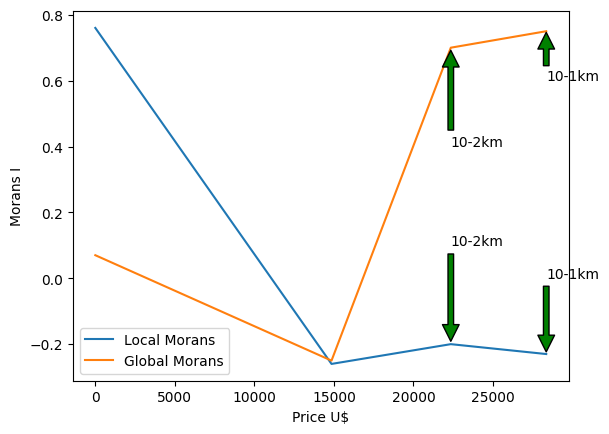

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('price.csv')
data = data.rename(columns={"Name": "name", "\tSensors": "sensors", "\tMorans Local": "Local Morans",
                           "\tMorans Global": "Global Morans", "\tPrice": "price"})
data.head()

plt.figure()
plt.plot(data['price'], data['Local Morans'], label='Local Morans')
plt.plot(data['price'], data['Global Morans'], label='Global Morans')
plt.xlabel("Price U$")
plt.ylabel("Morans I")
plt.annotate('10-1km', xy =(28350, -0.23),
                xytext =(28350, 0),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.annotate('10-2km', xy =(22350, -0.2),
                xytext =(22350, 0.1),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.annotate('10-1km', xy =(28350, 0.75),
                xytext =(28350, 0.6),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.annotate('10-2km', xy =(22350, 0.7),
                xytext =(22350, 0.4),
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.03),)
plt.legend()
plt.show()